In [3]:
import cPickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import interp
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))

In [5]:
X = df.body
y = df.label

In [10]:
y.value_counts()

NotHate         1012591
SizeHate         316422
GenderHate       189972
RaceHate          53331
ReligionHate       5769
Name: label, dtype: int64

In [4]:
# Binarize the output
# do I have the right classes? --> should match automatically.
y = label_binarize(y, classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate'])
n_classes = y.shape[1]

In [5]:
classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Use Count Vectorizer

In [8]:
countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english', tokenizer=None)

In [7]:
#Training vector
countv_fit_X_train = countv.fit_transform(X_train)
#test vector
countv_fit_X_test = countv.transform(X_test)

In [6]:
len(countv.vocabulary_)

289667

### Use multinomialNB

In [22]:
y_train

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ..., 
       [0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [18]:
classifier =  OneVsRestClassifier(MultinomialNB(), n_jobs=-1)

In [23]:
y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)

In [35]:
y_preds = classifier.fit(countv_fit_X_train, y_train).predict(countv_fit_X_test)

In [24]:
y_score

array([[  2.15714246e-01,   8.13028048e-01,   1.28182693e-04,
          6.62213253e-05,   6.28457831e-09],
       [  9.94299108e-01,   5.50896383e-04,   9.23164825e-04,
          1.03713359e-03,   8.28448543e-06],
       [  2.14796691e-01,   5.23176881e-02,   2.55909619e-01,
          2.84548854e-01,   6.16103066e-05],
       ..., 
       [  9.66630480e-01,   1.58305269e-03,   2.39487503e-03,
          6.76189168e-05,   1.70811927e-09],
       [  9.99999512e-01,   6.53181833e-14,   1.28681681e-05,
          7.25618263e-09,   1.40008026e-20],
       [  3.48994967e-02,   9.98119150e-01,   3.11026874e-04,
          1.42400853e-06,   1.71660824e-10]])

In [36]:
y_preds

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [30]:
classifier.classes_

array([0, 1, 2, 3, 4])

In [6]:
len(classifier.classes_)

NameError: name 'classifier' is not defined

In [8]:
def createmulticlassROC(n_classes, y_test, y_score):
    '''
    Function to create & plot ROC curve & associated areas
    Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    Inputs: n_classes: the number of classes
            y_test: the test labels
            y_score: the predicted probabilities for each class.   
                (e.g. y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test) )
    '''
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize = (12,8))

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for multi-class')
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


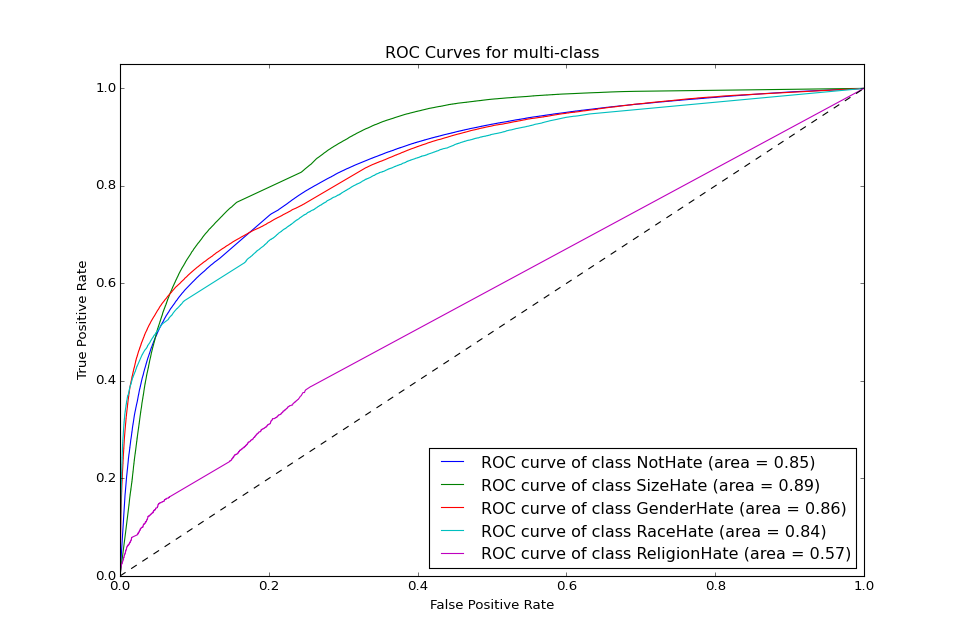

In [58]:
createmulticlassROC(n_classes, y_test, y_score)

In [60]:
print(roc_auc_score(y_test, y_score))

0.80189730491362821

In [59]:
print(classification_report(y_test, y_preds))

             precision    recall  f1-score   support

          0       0.84      0.82      0.83    304440
          1       0.64      0.65      0.65     94369
          2       0.64      0.52      0.57     56937
          3       0.65      0.33      0.43     15963
          4       0.04      0.01      0.01      1717

avg / total       0.77      0.73      0.74    473426



### Run the problem, adding in a tokenizer function to lemmatize/stem words

In [9]:
#from http://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn


stemmer = SnowballStemmer("english")

def stem_tokens(tokens, stemmer):
    stemmed=[]
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

    

In [67]:
testphrase = "This is my test phrase. OMG!"
countv = CountVectorizer(decode_error = 'ignore', stop_words = 'english', tokenizer=tokenize)
test_ft_vect = countv.fit_transform(testphrase)

In [77]:
test_ft_vect.todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0

In [88]:
#Run count vectorizer with stemming

countvtok = CountVectorizer(decode_error = 'ignore', stop_words = 'english', tokenizer=tokenize)

In [89]:
#Training vector
#took ~30 minutes to run
countvtok_fit_X_train = countv.fit_transform(X_train)

In [90]:
#test vector
countvtok_fit_X_test = countv.transform(X_test)

<IPython.core.display.Javascript object>


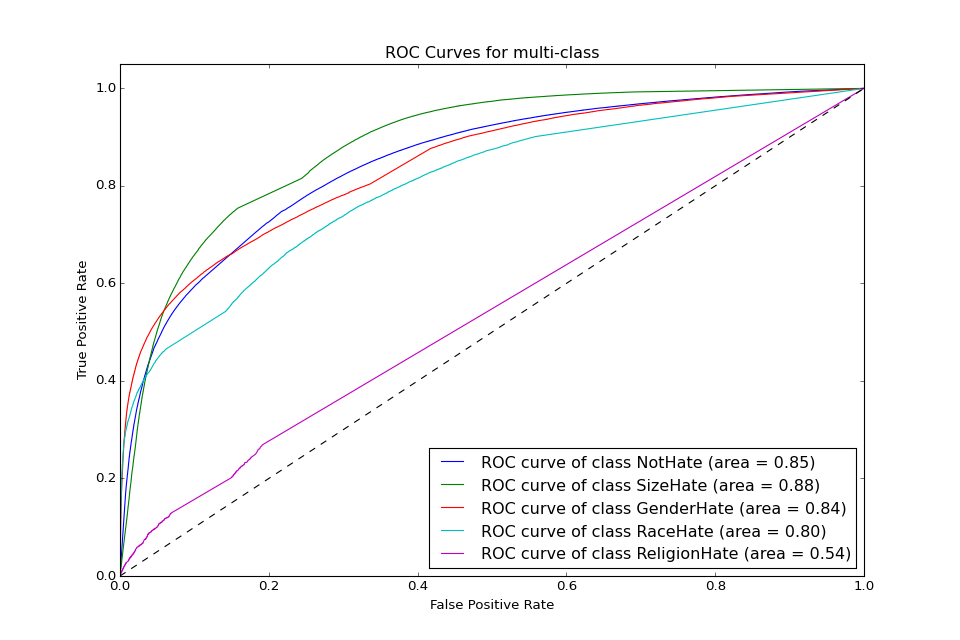

0.784213227881
             precision    recall  f1-score   support

          0       0.83      0.82      0.83    304440
          1       0.65      0.62      0.63     94369
          2       0.68      0.47      0.55     56937
          3       0.70      0.24      0.36     15963
          4       0.02      0.00      0.00      1717

avg / total       0.77      0.72      0.74    473426



In [91]:
classifier =  OneVsRestClassifier(MultinomialNB(), n_jobs=-1)
ytok_score = classifier.fit(countvtok_fit_X_train, y_train).predict_proba(countvtok_fit_X_test)
ytok_preds = classifier.fit(countvtok_fit_X_train, y_train).predict(countvtok_fit_X_test)
createmulticlassROC(n_classes, ytok_test, ytok_score)
print(roc_auc_score(y_test, ytok_score))
print(classification_report(y_test, ytok_preds))

In [13]:
# Try GradientBoostingClassifier, with UNtokenized count vectorizer
classifier =  OneVsRestClassifier(GradientBoostingClassifier(max_features=2000), n_jobs=-1)

In [14]:
y_score = classifier.fit(countv_fit_X_train.toarray(), y_train).predict_proba(countv_fit_X_test.toarray())

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
/Users/emily/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='IPython.kernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'IPython.kernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
/Users/emily/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10350d2b0, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='IPython.kernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10350d2b0, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from IPython.kernel.zmq import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/config/application.py in launch_instance(cls=<class 'IPython.kernel.zmq.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    569         
    570         If a global instance already exists, this reinitializes and starts it
    571         """
    572         app = cls.instance(**kwargs)
    573         app.initialize(argv)
--> 574         app.start()
        app.start = <bound method IPKernelApp.start of <IPython.kernel.zmq.kernelapp.IPKernelApp object>>
    575 
    576 #-----------------------------------------------------------------------------
    577 # utility functions, for convenience
    578 #-----------------------------------------------------------------------------

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelapp.py in start(self=<IPython.kernel.zmq.kernelapp.IPKernelApp object>)
    368     def start(self):
    369         if self.poller is not None:
    370             self.poller.start()
    371         self.kernel.start()
    372         try:
--> 373             ioloop.IOLoop.instance().start()
    374         except KeyboardInterrupt:
    375             pass
    376 
    377 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    835                 self._events.update(event_pairs)
    836                 while self._events:
    837                     fd, events = self._events.popitem()
    838                     try:
    839                         fd_obj, handler_func = self._handlers[fd]
--> 840                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    841                     except (OSError, IOError) as e:
    842                         if errno_from_exception(e) == errno.EPIPE:
    843                             # Happens when the client closes the connection
    844                             pass

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatch_shell(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['E069F48E4D3A4C2C8CC3B7F409B643C4']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in execute_request(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['E069F48E4D3A4C2C8CC3B7F409B643C4'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '3ED13AB8D1A04DBDBC6C5275050602A8', 'msg_type': 'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360         
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/ipkernel.py in do_execute(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, code=u'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    176 
    177         reply_content = {}
    178         # FIXME: the shell calls the exception handler itself.
    179         shell._reply_content = None
    180         try:
--> 181             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = u'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)'
        store_history = True
        silent = False
    182         except:
    183             status = u'error'
    184             # FIXME: this code right now isn't being used yet by default,
    185             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, raw_cell=u'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)', store_history=True, silent=False, shell_futures=True)
   2866                 self.displayhook.exec_result = result
   2867 
   2868                 # Execute the user code
   2869                 interactivity = "none" if silent else self.ast_node_interactivity
   2870                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2871                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2872 
   2873                 # Reset this so later displayed values do not modify the
   2874                 # ExecutionResult
   2875                 self.displayhook.exec_result = None

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-14-816756ad3775>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2970 
   2971         try:
   2972             for i, node in enumerate(to_run_exec):
   2973                 mod = ast.Module([node])
   2974                 code = compiler(mod, cell_name, "exec")
-> 2975                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10c3319b0, file "<ipython-input-14-816756ad3775>", line 1>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2976                     return True
   2977 
   2978             for i, node in enumerate(to_run_interactive):
   2979                 mod = ast.Interactive([node])

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10c3319b0, file "<ipython-input-14-816756ad3775>", line 1>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3030         outflag = 1  # happens in more places, so it's easier as default
   3031         try:
   3032             try:
   3033                 self.hooks.pre_run_code_hook()
   3034                 #rprint('Running code', repr(code_obj)) # dbg
-> 3035                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10c3319b0, file "<ipython-input-14-816756ad3775>", line 1>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u"df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))", u'X = df.body\ny = df.label', u"# Binarize the output\n# do I have the right c...eHate', 'ReligionHate'])\nn_classes = y.shape[1]", u"classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']", u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)', u"countv = CountVectorizer(decode_error = 'ignor...or\ncountv_fit_X_test = countv.transform(X_test)", u'def createmulticlassROC(n_classes, y_test, y_s...   plt.legend(loc="lower right")\n    plt.show()', u'#from http://stackoverflow.com/questions/26126...okens(tokens, stemmer)\n    return stems\n\n    ', u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u'# Try GradientBoostingClassifier, with UNtoken...oostingClassifier(max_features=2000), n_jobs=-1)', u'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)'], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {}, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': 0                                &gt;maybe jews\...ow protein, bad amin...
Name: body, dtype: object, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u"df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))", u'X = df.body\ny = df.label', u"# Binarize the output\n# do I have the right c...eHate', 'ReligionHate'])\nn_classes = y.shape[1]", u"classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']", u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)', u"countv = CountVectorizer(decode_error = 'ignor...or\ncountv_fit_X_test = countv.transform(X_test)", u'def createmulticlassROC(n_classes, y_test, y_s...   plt.legend(loc="lower right")\n    plt.show()', u'#from http://stackoverflow.com/questions/26126...okens(tokens, stemmer)\n    return stems\n\n    ', u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u'# Try GradientBoostingClassifier, with UNtoken...oostingClassifier(max_features=2000), n_jobs=-1)', u'y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)'], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {}, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': 0                                &gt;maybe jews\...ow protein, bad amin...
Name: body, dtype: object, ...}
   3036             finally:
   3037                 # Reset our crash handler in place
   3038                 sys.excepthook = old_excepthook
   3039         except SystemExit as e:

...........................................................................
/Users/emily/Documents/Galvanize/Project/OnlineHateSpeech/Scripts/<ipython-input-14-816756ad3775> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)
      7 
      8 
      9 
     10 

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py in fit(self=OneVsRestClassifier(estimator=GradientBoostingCl...          warm_start=False),
          n_jobs=-1), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
...
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]]))
    278         # of spawning threads.  See joblib issue #112.
    279         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)
    280              (self.estimator, X, column,
    281               classes=["not %s" % self.label_binarizer_.classes_[i],
    282                        self.label_binarizer_.classes_[i]])
--> 283               for i, column in enumerate(columns))
        columns = <generator object <genexpr>>
    284 
    285         return self
    286 
    287     def predict(self, X):

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    661             if pre_dispatch == "all" or n_jobs == 1:
    662                 # The iterable was consumed all at once by the above for loop.
    663                 # No need to wait for async callbacks to trigger to
    664                 # consumption.
    665                 self._iterating = False
--> 666             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    667             # Make sure that we get a last message telling us we are done
    668             elapsed_time = time.time() - self._start_time
    669             self._print('Done %3i out of %3i | elapsed: %s finished',
    670                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    TypeError                                          Tue Dec 22 14:12:44 2015
PID: 676                    Python 2.7.11: /Users/emily/anaconda/bin/python
...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/multiclass.pyc in _fit_binary(estimator=GradientBoostingClassifier(init=None, learning_r...e=1.0, verbose=0,
              warm_start=False), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), classes=['not 0', 0])
     69             warnings.warn("Label %s is present in all training examples." %
     70                           str(classes[c]))
     71         estimator = _ConstantPredictor().fit(X, unique_y)
     72     else:
     73         estimator = clone(estimator)
---> 74         estimator.fit(X, y)
     75     return estimator
     76 
     77 
     78 def _predict_binary(estimator, X):

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.pyc in fit(self=GradientBoostingClassifier(init=None, learning_r...e=1.0, verbose=0,
              warm_start=False), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), sample_weight=None, monitor=None)
    936         # if not warmstart - clear the estimator state
    937         if not self.warm_start:
    938             self._clear_state()
    939 
    940         # Check input
--> 941         X, y = check_X_y(X, y, dtype=DTYPE)
    942         n_samples, self.n_features = X.shape
    943         if sample_weight is None:
    944             sample_weight = np.ones(n_samples, dtype=np.float32)
    945         else:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in check_X_y(X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False)
    439     X_converted : object
    440         The converted and validated X.
    441     """
    442     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    443                     ensure_2d, allow_nd, ensure_min_samples,
--> 444                     ensure_min_features)
    445     if multi_output:
    446         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    447                         dtype=None)
    448     else:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in check_array(array=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1)
    329 
    330     if sp.issparse(array):
    331         if dtype_numeric:
    332             dtype = None
    333         array = _ensure_sparse_format(array, accept_sparse, dtype, order,
--> 334                                       copy, force_all_finite)
        array = <1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>
    335     else:
    336         if ensure_2d:
    337             array = np.atleast_2d(array)
    338         if dtype_numeric:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in _ensure_sparse_format(spmatrix=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True)
    234     -------
    235     spmatrix_converted : scipy sparse matrix.
    236         Matrix that is ensured to have an allowed type.
    237     """
    238     if accept_sparse is None:
--> 239         raise TypeError('A sparse matrix was passed, but dense '
        dtype = <type 'numpy.float32'>
    240                         'data is required. Use X.toarray() to '
    241                         'convert to a dense numpy array.')
    242     sparse_type = spmatrix.format
    243     if dtype is None:

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
___________________________________________________________________________

In [12]:
y_preds = classifier.fit(countv_fit_X_train.toarray(), y_train).predict(countv_fit_X_test.toarray())
createmulticlassROC(n_classes, y_test, y_score)
print(roc_auc_score(y_test, y_score))
print(classification_report(y_test, y_preds))

JoblibTypeError: JoblibTypeError
___________________________________________________________________________
Multiprocessing exception:
    ...........................................................................
/Users/emily/anaconda/lib/python2.7/runpy.py in _run_module_as_main(mod_name='IPython.kernel.__main__', alter_argv=1)
    157     pkg_name = mod_name.rpartition('.')[0]
    158     main_globals = sys.modules["__main__"].__dict__
    159     if alter_argv:
    160         sys.argv[0] = fname
    161     return _run_code(code, main_globals, None,
--> 162                      "__main__", fname, loader, pkg_name)
        fname = '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'IPython.kernel'
    163 
    164 def run_module(mod_name, init_globals=None,
    165                run_name=None, alter_sys=False):
    166     """Execute a module's code without importing it

...........................................................................
/Users/emily/anaconda/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x10350d2b0, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='IPython.kernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x10350d2b0, file "/Use...ite-packages/IPython/kernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'IPython.kernel', 'app': <module 'IPython.kernel.zmq.kernelapp' from '/Us.../site-packages/IPython/kernel/zmq/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from IPython.kernel.zmq import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/config/application.py in launch_instance(cls=<class 'IPython.kernel.zmq.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    569         
    570         If a global instance already exists, this reinitializes and starts it
    571         """
    572         app = cls.instance(**kwargs)
    573         app.initialize(argv)
--> 574         app.start()
        app.start = <bound method IPKernelApp.start of <IPython.kernel.zmq.kernelapp.IPKernelApp object>>
    575 
    576 #-----------------------------------------------------------------------------
    577 # utility functions, for convenience
    578 #-----------------------------------------------------------------------------

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelapp.py in start(self=<IPython.kernel.zmq.kernelapp.IPKernelApp object>)
    368     def start(self):
    369         if self.poller is not None:
    370             self.poller.start()
    371         self.kernel.start()
    372         try:
--> 373             ioloop.IOLoop.instance().start()
    374         except KeyboardInterrupt:
    375             pass
    376 
    377 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    146             PollIOLoop.configure(ZMQIOLoop)
    147         return PollIOLoop.instance()
    148     
    149     def start(self):
    150         try:
--> 151             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    152         except ZMQError as e:
    153             if e.errno == ETERM:
    154                 # quietly return on ETERM
    155                 pass

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    835                 self._events.update(event_pairs)
    836                 while self._events:
    837                     fd, events = self._events.popitem()
    838                     try:
    839                         fd_obj, handler_func = self._handlers[fd]
--> 840                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    841                     except (OSError, IOError) as e:
    842                         if errno_from_exception(e) == errno.EPIPE:
    843                             # Happens when the client closes the connection
    844                             pass

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    428             # dispatch events:
    429             if events & IOLoop.ERROR:
    430                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    431                 return
    432             if events & IOLoop.READ:
--> 433                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    434                 if not self.socket:
    435                     return
    436             if events & IOLoop.WRITE:
    437                 self._handle_send()

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    460                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    461         else:
    462             if self._recv_callback:
    463                 callback = self._recv_callback
    464                 # self._recv_callback = None
--> 465                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    466                 
    467         # self.update_state()
    468         
    469 

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    402         close our socket."""
    403         try:
    404             # Use a NullContext to ensure that all StackContexts are run
    405             # inside our blanket exception handler rather than outside.
    406             with stack_context.NullContext():
--> 407                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    408         except:
    409             gen_log.error("Uncaught exception, closing connection.",
    410                           exc_info=True)
    411             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    247         if self.control_stream:
    248             self.control_stream.on_recv(self.dispatch_control, copy=False)
    249 
    250         def make_dispatcher(stream):
    251             def dispatcher(msg):
--> 252                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    253             return dispatcher
    254 
    255         for s in self.shell_streams:
    256             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in dispatch_shell(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Try GradientBoostingClassifier, with UNtokeniz...e))\nprint(classification_report(y_test, y_preds))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'parent_header': {}})
    208         else:
    209             # ensure default_int_handler during handler call
    210             sig = signal(SIGINT, default_int_handler)
    211             self.log.debug("%s: %s", msg_type, msg)
    212             try:
--> 213                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <IPython.kernel.zmq.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['E069F48E4D3A4C2C8CC3B7F409B643C4']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Try GradientBoostingClassifier, with UNtokeniz...e))\nprint(classification_report(y_test, y_preds))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'parent_header': {}}
    214             except Exception:
    215                 self.log.error("Exception in message handler:", exc_info=True)
    216             finally:
    217                 signal(SIGINT, sig)

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/kernelbase.py in execute_request(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['E069F48E4D3A4C2C8CC3B7F409B643C4'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Try GradientBoostingClassifier, with UNtokeniz...e))\nprint(classification_report(y_test, y_preds))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'session': 'E069F48E4D3A4C2C8CC3B7F409B643C4', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'C9CB27EA119647C48B14E4213B2F6005', 'msg_type': 'execute_request', 'parent_header': {}})
    357         if not silent:
    358             self.execution_count += 1
    359             self._publish_execute_input(code, parent, self.execution_count)
    360         
    361         reply_content = self.do_execute(code, silent, store_history,
--> 362                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    363 
    364         # Flush output before sending the reply.
    365         sys.stdout.flush()
    366         sys.stderr.flush()

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/kernel/zmq/ipkernel.py in do_execute(self=<IPython.kernel.zmq.ipkernel.IPythonKernel object>, code=u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    176 
    177         reply_content = {}
    178         # FIXME: the shell calls the exception handler itself.
    179         shell._reply_content = None
    180         try:
--> 181             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))'
        store_history = True
        silent = False
    182         except:
    183             status = u'error'
    184             # FIXME: this code right now isn't being used yet by default,
    185             # because the run_cell() call above directly fires off exception

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, raw_cell=u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', store_history=True, silent=False, shell_futures=True)
   2866                 self.displayhook.exec_result = result
   2867 
   2868                 # Execute the user code
   2869                 interactivity = "none" if silent else self.ast_node_interactivity
   2870                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2871                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2872 
   2873                 # Reset this so later displayed values do not modify the
   2874                 # ExecutionResult
   2875                 self.displayhook.exec_result = None

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Print object>, <_ast.Print object>], cell_name='<ipython-input-12-d97562197819>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2970 
   2971         try:
   2972             for i, node in enumerate(to_run_exec):
   2973                 mod = ast.Module([node])
   2974                 code = compiler(mod, cell_name, "exec")
-> 2975                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <I....kernel.zmq.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x10883eeb0, file "<ipython-input-12-d97562197819>", line 4>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2976                     return True
   2977 
   2978             for i, node in enumerate(to_run_interactive):
   2979                 mod = ast.Interactive([node])

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<IPython.kernel.zmq.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x10883eeb0, file "<ipython-input-12-d97562197819>", line 4>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   3030         outflag = 1  # happens in more places, so it's easier as default
   3031         try:
   3032             try:
   3033                 self.hooks.pre_run_code_hook()
   3034                 #rprint('Running code', repr(code_obj)) # dbg
-> 3035                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x10883eeb0, file "<ipython-input-12-d97562197819>", line 4>
        self.user_global_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u"df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))", u'X = df.body\ny = df.label', u"# Binarize the output\n# do I have the right c...eHate', 'ReligionHate'])\nn_classes = y.shape[1]", u"classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']", u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)', u"countv = CountVectorizer(decode_error = 'ignor...or\ncountv_fit_X_test = countv.transform(X_test)", u'def createmulticlassROC(n_classes, y_test, y_s...   plt.legend(loc="lower right")\n    plt.show()', u'#from http://stackoverflow.com/questions/26126...okens(tokens, stemmer)\n    return stems\n\n    ', u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))'], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {}, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': 0                                &gt;maybe jews\...ow protein, bad amin...
Name: body, dtype: object, ...}
        self.user_ns = {'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'HashingVectorizer': <class 'sklearn.feature_extraction.text.HashingVectorizer'>, 'In': ['', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u"df = pickle.load(open('../Data/labeledhate_5cats.p', 'rb'))", u'X = df.body\ny = df.label', u"# Binarize the output\n# do I have the right c...eHate', 'ReligionHate'])\nn_classes = y.shape[1]", u"classes=['NotHate', 'SizeHate', 'GenderHate', 'RaceHate', 'ReligionHate']", u'X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)', u"countv = CountVectorizer(decode_error = 'ignor...or\ncountv_fit_X_test = countv.transform(X_test)", u'def createmulticlassROC(n_classes, y_test, y_s...   plt.legend(loc="lower right")\n    plt.show()', u'#from http://stackoverflow.com/questions/26126...okens(tokens, stemmer)\n    return stems\n\n    ', u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))', u"import cPickle as pickle\nfrom sklearn.feature...plt\nget_ipython().magic(u'matplotlib notebook')", u'# Try GradientBoostingClassifier, with UNtoken...)\nprint(classification_report(y_test, y_preds))'], 'MultinomialNB': <class 'sklearn.naive_bayes.MultinomialNB'>, 'OneVsRestClassifier': <class 'sklearn.multiclass.OneVsRestClassifier'>, 'Out': {}, 'SnowballStemmer': <class 'nltk.stem.snowball.SnowballStemmer'>, 'TfidfVectorizer': <class 'sklearn.feature_extraction.text.TfidfVectorizer'>, 'X': 0                                &gt;maybe jews\...ow protein, bad amin...
Name: body, dtype: object, ...}
   3036             finally:
   3037                 # Reset our crash handler in place
   3038                 sys.excepthook = old_excepthook
   3039         except SystemExit as e:

...........................................................................
/Users/emily/Documents/Galvanize/Project/OnlineHateSpeech/Scripts/<ipython-input-12-d97562197819> in <module>()
      1 
      2 
      3 # Try GradientBoostingClassifier, with UNtokenized count vectorizer
----> 4 classifier =  OneVsRestClassifier(GradientBoostingClassifier(max_features=2000), n_jobs=-1)
      5 
      6 y_score = classifier.fit(countv_fit_X_train, y_train).predict_proba(countv_fit_X_test)
      7 y_preds = classifier.fit(countv_fit_X_train, y_train).predict(countv_fit_X_test)
      8 createmulticlassROC(n_classes, y_test, y_score)
      9 print(roc_auc_score(y_test, y_score))
     10 print(classification_report(y_test, y_preds))

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/multiclass.py in fit(self=OneVsRestClassifier(estimator=GradientBoostingCl...          warm_start=False),
          n_jobs=-1), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
...
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]]))
    278         # of spawning threads.  See joblib issue #112.
    279         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)
    280              (self.estimator, X, column,
    281               classes=["not %s" % self.label_binarizer_.classes_[i],
    282                        self.label_binarizer_.classes_[i]])
--> 283               for i, column in enumerate(columns))
        columns = <generator object <genexpr>>
    284 
    285         return self
    286 
    287     def predict(self, X):

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    661             if pre_dispatch == "all" or n_jobs == 1:
    662                 # The iterable was consumed all at once by the above for loop.
    663                 # No need to wait for async callbacks to trigger to
    664                 # consumption.
    665                 self._iterating = False
--> 666             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    667             # Make sure that we get a last message telling us we are done
    668             elapsed_time = time.time() - self._start_time
    669             self._print('Done %3i out of %3i | elapsed: %s finished',
    670                         (len(self._output),

    ---------------------------------------------------------------------------
    Sub-process traceback:
    ---------------------------------------------------------------------------
    TypeError                                          Tue Dec 22 14:11:27 2015
PID: 669                    Python 2.7.11: /Users/emily/anaconda/bin/python
...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/multiclass.pyc in _fit_binary(estimator=GradientBoostingClassifier(init=None, learning_r...e=1.0, verbose=0,
              warm_start=False), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), classes=['not 0', 0])
     69             warnings.warn("Label %s is present in all training examples." %
     70                           str(classes[c]))
     71         estimator = _ConstantPredictor().fit(X, unique_y)
     72     else:
     73         estimator = clone(estimator)
---> 74         estimator.fit(X, y)
     75     return estimator
     76 
     77 
     78 def _predict_binary(estimator, X):

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/ensemble/gradient_boosting.pyc in fit(self=GradientBoostingClassifier(init=None, learning_r...e=1.0, verbose=0,
              warm_start=False), X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), sample_weight=None, monitor=None)
    936         # if not warmstart - clear the estimator state
    937         if not self.warm_start:
    938             self._clear_state()
    939 
    940         # Check input
--> 941         X, y = check_X_y(X, y, dtype=DTYPE)
    942         n_samples, self.n_features = X.shape
    943         if sample_weight is None:
    944             sample_weight = np.ones(n_samples, dtype=np.float32)
    945         else:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in check_X_y(X=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, y=array([1, 1, 0, ..., 0, 1, 0]), accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=False, ensure_min_samples=1, ensure_min_features=1, y_numeric=False)
    439     X_converted : object
    440         The converted and validated X.
    441     """
    442     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    443                     ensure_2d, allow_nd, ensure_min_samples,
--> 444                     ensure_min_features)
    445     if multi_output:
    446         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    447                         dtype=None)
    448     else:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in check_array(array=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1)
    329 
    330     if sp.issparse(array):
    331         if dtype_numeric:
    332             dtype = None
    333         array = _ensure_sparse_format(array, accept_sparse, dtype, order,
--> 334                                       copy, force_all_finite)
        array = <1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>
    335     else:
    336         if ensure_2d:
    337             array = np.atleast_2d(array)
    338         if dtype_numeric:

...........................................................................
/Users/emily/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.pyc in _ensure_sparse_format(spmatrix=<1104659x289667 sparse matrix of type '<type 'nu... stored elements in Compressed Sparse Row format>, accept_sparse=None, dtype=<type 'numpy.float32'>, order=None, copy=False, force_all_finite=True)
    234     -------
    235     spmatrix_converted : scipy sparse matrix.
    236         Matrix that is ensured to have an allowed type.
    237     """
    238     if accept_sparse is None:
--> 239         raise TypeError('A sparse matrix was passed, but dense '
        dtype = <type 'numpy.float32'>
    240                         'data is required. Use X.toarray() to '
    241                         'convert to a dense numpy array.')
    242     sparse_type = spmatrix.format
    243     if dtype is None:

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.
___________________________________________________________________________